**Welcome to Assignment 4 on Deep Learning for Computer Vision.**

This assignment consists of three parts. Part-1 is based on the content you learned in Week-7 of course and Part-2 is based on the content you learned in Week-8 of the course. 


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

## Triplet loss:

In this question you will implement triplet loss for MNIST dataset.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
from PIL import Image
import timeit
from torchvision.datasets import MNIST
from torchvision import transforms

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
########################

cuda = torch.cuda.is_available()
#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
device =  "cuda" if cuda else "cpu"
#### YOUR CODE ENDS HERE ####


In [2]:

#Prepare dataset
train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))
n_classes = 10


###Create dataset for Triplet Network

In [3]:
class TripletDataset(Dataset):
    """
    This program returns anchor, positive and negative sample for training 
    Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform
        # prepare labels and data for extracting positive and negative samples during training
        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        #### YOUR CODE STARTS HERE ####
        # Refering to the above code where we prepared labels and data for testing, please prepare test samples
        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}
       #### YOUR CODE ENDS HERE ####
            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
          #### YOUR CODE STARTS HERE ####
            # assign train_data[index] to anchor and train_label[index] item() to label1 
            anchor, label1 = self.train_data[index] , self.train_labels[index].item()
          #### YOUR CODE ENDS HERE ####
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            positive = self.train_data[positive_index]
            negative = self.train_data[negative_index]
        else:
           #### YOUR CODE STARTS HERE ####
             # assign test_triplets[index][0] to anchor, test_triplets[index][1] as positive sample and test_triplets[index][2]
            anchor = self.test_data[self.test_triplets[index][0]]
            positive = self.test_data[self.test_triplets[index][1]]
            negative = self.test_data[self.test_triplets[index][2]]
           #### YOUR CODE ENDS HERE ####

        anchor = Image.fromarray(anchor.numpy(), mode='L')
        positive = Image.fromarray(positive.numpy(), mode='L')
        negative = Image.fromarray(negative.numpy(), mode='L')
        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return (anchor, positive, negative), []

    def __len__(self):
        return len(self.mnist_dataset)

In [4]:
#### YOUR CODE STARTS HERE ####
# define the training and test sets
# use TripletDataset
# pass train_dataset for triplet_train_dataset and test_datset for triplet_test_dataset
triplet_train_dataset = TripletDataset(train_dataset)
triplet_test_dataset = TripletDataset(test_dataset)
#### YOUR CODE ENDS HERE ####
batch_size = 128
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\Asus\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Asus\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Asus\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Users\Asus\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [5]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # Define a sequential block as per the instructions below:
        # Build three blocks with each block containing: Conv->PReLU->Maxpool2d layers
        # Three conv layers should have 16, 32, 64 output channels respectively
        # Use convolution kernel size 3
        # For maxpool use a kernel size of 2 and stride of 2

        self.convnet = nn.Sequential( nn.Conv2d(1,16,3),
                                      nn.PReLU(),
                                      nn.MaxPool2d(2,stride=2),
                                      nn.Conv2d(16,32,3),
                                      nn.PReLU(),
                                      nn.MaxPool2d(2,stride=2),
                                      nn.Conv2d(32,64,3),
                                      nn.PReLU(),
                                      nn.MaxPool2d(2,stride=2)
                                     )


        # Define linear->PReLU->linear->PReLU->linear
        # The first two linear layers should have 256 and 128 output nodes
        # The final FC layer should have 2 nodes
        self.fc = nn.Sequential(nn.Linear(64*1*1,256),
                                nn.PReLU(),
                                nn.Linear(256,128),
                                nn.PReLU(),
                                nn.Linear(128,2))
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
      #### YOUR CODE STARTS HERE ####
        # Define the forward pass, convnet -> fc
        output = self.convnet(x)
        output = output.view(-1,64*1*1)
        output = self.fc(output)
        #### YOUR CODE ENDS HERE ####
        return output

In [6]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
      #### YOUR CODE STARTS HERE ####
      # Call the embedding network for anchor,positive and negative samples (x1,x2,x3)
        output1 = self.embedding_net.forward(x1)
        output2 = self.embedding_net.forward(x2)
        output3 = self.embedding_net.forward(x3)
      #### YOUR CODE ENDS HERE ####
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [17]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def calc_euclidean(self, x1, x2):
        return ((x1 - x2).pow(2).sum(1)).pow(0.5)

    def forward(self, anchor, positive, negative, size_average=True):
      #### YOUR CODE STARTS HERE ####
        # calculate the eucledian distance between anchor and positive sample
        #positive_distance = torch.cdist(anchor,positive)
        positive_distance = self.calc_euclidean(anchor, positive)
        # calculate the eucledian distance between anchor and negative sample
        #negative_distance = torch.cdist(anchor,negative)
        negative_distance = self.calc_euclidean(anchor, negative)
      #### YOUR CODE ENDS HERE #### 
        losses = F.relu(positive_distance - negative_distance + self.margin)
        return losses.mean() if size_average else losses.sum()

In [18]:
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()
                
        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

In [20]:
def test_epoch(val_loader, model, loss_fn, cuda):
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            

    return val_loss

In [21]:
n_epochs=2
for epoch in range(n_epochs):
        train_loss= train_epoch(triplet_train_loader, model, loss_fn, optimizer, cuda)
        print('\nEpoch: {}/{}. Training: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss))
        test_loss= test_epoch(triplet_test_loader, model, loss_fn, cuda)
        test_loss /= len(triplet_test_loader)
        print('\nEpoch: {}/{}. Testing: Average loss: {:.4f}'.format(epoch + 1, n_epochs,test_loss))


Epoch: 1/2. Training: Average loss: 0.1939

Epoch: 1/2. Testing: Average loss: 0.1202

Epoch: 2/2. Training: Average loss: 0.0940

Epoch: 2/2. Testing: Average loss: 0.0865


## Question 1:

What is the average test loss obtained after training MNIST on triplet loss for two epochs?

1.   0.5487
2.   0.1039
3.   0.8735
4.   0.9924

Write code to calculate IoU between aligned predicted bounding-boxes bbox_p and ground-truth bounding-boxes bbox_gt. Assume a co-ordinate system that has origin (0,0) at the upper-left corner of the image, and to the right and down are +ve directions of x-axis and y-axis respectively.

In [30]:
def calculate_iou(bbox_p, bbox_gt):
    #input: bbox_p and bbox_gt are 4 dimensional tensors
    #output: ious (N,) vector
    
    #### YOUR CODE STARTS HERE ####
    # write code to compute the IoU between the bounding boxes
    # find the top-left point of intersection of predicted and ground truth bounding boxes
    #Hint : if the top left points of box1=(10,20) and box2=(30,10) the point of interestion is (30,20)
    xA = max(bbox_p[0],bbox_gt[0])
    yA = max(bbox_p[1],bbox_gt[1])
    # find the bottom-right point of intersection of predicted and ground truth bounding boxes
    #Hint : if the bottom-right points of box1=(20,30) and box2=(10,40) the point of interestion is (10,30)
    xB = min(bbox_p[2],bbox_gt[2])
    yB = min(bbox_p[3],bbox_gt[3])
    #Find the width of overlapping region
    # Hint: Try to imagine a rectangle whose top left corner is (xA,yA) and bottom right corner is (xB,yB)
    overlap_width= yB-yA
    if overlap_width<0:
        overlap_width=0
   #Find the height of overlapping region
    overlap_ht= xB-xA
    if overlap_ht<0:
        overlap_ht=0
    #Find the area of overlapping region
    interArea = overlap_width*overlap_ht
    box_width=bbox_p[2] - bbox_p[0]
    box_ht=bbox_p[3] - bbox_p[1]
    bbox_pArea = box_width*box_ht
    bbox_gtArea = (bbox_gt[2] - bbox_gt[0] ) * (bbox_gt[3] - bbox_gt[1] )
    #Calculate IOU
    # you can refer to slide number 13 of week7_part1
    # A union B= A+B-(A intersection B)
    iou = interArea / float(bbox_pArea + bbox_gtArea - interArea)
    #### YOUR CODE ENDS HERE ####
    
    return iou

In [31]:
bbox_p=[45, 66, 203, 112]
bbox_gt=[54, 66, 198, 114]
print(calculate_iou(bbox_p, bbox_gt))

0.8766543144520911


## Question 2:

What is the Intersection Over Union value (rounded to three digits) for 


predicted bounding box=[45, 66, 203, 112]


ground truth bounding box=[54, 66, 198, 114]

1.   0.456
2.   0.589
3.   0.877
4.   0.253

We will implement Focal Loss by extending the nn class of pytorch. Given the predicted scoress and one-hot encoding of actual labels, it should return the loss value. Arxiv link to the research paper that proposed focal loss is given below.

In [25]:
class FocalLoss(nn.Module):
    'Focal Loss - https://arxiv.org/abs/1708.02002'

    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred_logits, target):
        pred = pred_logits.sigmoid()
        ce = F.binary_cross_entropy_with_logits(pred_logits, target, reduction='none')
        #### YOUR CODE STARTS HERE ####
        # Refer equation (2) of the focal loss paper to find pt
        pt = torch.where(target==1, pred, 1-pred)
        # Refer to equation (5) of the focal loss paper to find F_loss
        #assume ce=log(pt), alpha=self.alpha and gamma=self.gamma
        F_loss= -self.alpha*((1-pt)**self.gamma)*ce
        #### YOUR CODE ENDS HERE ####
        return torch.mean(F_loss)


In [26]:

# Assume predicted is the predicted score
predicted_score=torch.tensor([[2.8189, 2.8334, 2.8816, 2.8754, 2.7178, 2.9008, 2.9511, 2.9113],
  [3.0138, 3.1324, 3.1453, 3.1421, 3.0259, 3.0763, 2.9275, 3.0247],
  [3.1808, 3.2000, 3.2535, 3.3548, 3.2533, 3.2937, 3.2101, 3.2429]])
#One hot encoding of the actual labels
actual_label=torch.tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]])


In [27]:
# create an object of FocalLoss
focal_loss=FocalLoss(alpha=2, gamma=5)


In [28]:
 #### YOUR CODE STARTS HERE ####
#Calculate focal loss between predicted_score and actual_label
#Use the focal_loss object created above
#Print the value
loss = focal_loss.forward(predicted_score,actual_label)
print(loss)
#### YOUR CODE ENDS HERE ####

tensor(-4.3208)


In [49]:
# x = torch.randn(3, 2)
# y = torch.randn(3, 2)


# z = torch.where(x > 0, x, y)
# print(x,y,z)

tensor([[ 0.1870,  1.0845],
        [-0.8132,  1.2791],
        [-1.4758,  0.3695]]) tensor([[ 2.6829, -1.9958],
        [ 0.6014,  0.9072],
        [-0.6664, -0.7910]]) tensor([[ 0.1870,  1.0845],
        [ 0.6014,  1.2791],
        [-0.6664,  0.3695]])


## Question 3:

What is the value of focal loss obtained above?

1.   4.3208
2.   9.6345
3.   1.8743
4.   8.2538

# Part-2

Time series prediction using recurrent models. 

Use the airline-passengers.csv file for this task.

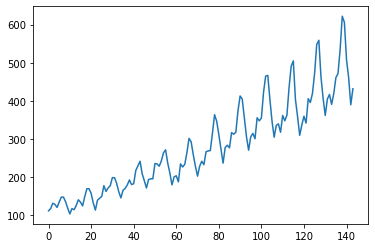

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

training_set = pd.read_csv('airline-passengers.csv')


training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Prepare the training and testing dataset.


In [10]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Create the model

In [11]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        #### YOUR CODE STARTS HERE ####
        # define a lstm block with input size=input_size, hidden_size and num_layers, batch_first=True and a fc block with hidden_size as input and num_classes as output
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,num_layers=self.num_layers,batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size,self.num_classes)
        #### YOUR CODE ENDS HERE ####
    def forward(self, x):
       
        
        # Define a forward function for the LSTM block
        batch_size = x.size(0)
        hidden_state = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size))
        
        cell_state = hidden_state
        #### YOUR CODE STARTS HERE ####
        # Propagate input through LSTM
        # pass the input, hidden state and cell_state
        output, (hidden_out, cell_out) = self.lstm(x)
        
        #flatten hidden_out and pass it through fc layer
        hidden_out =  hidden_out.view(-1,self.hidden_size)
        
        out = self.fc(hidden_out)
        #### YOUR CODE ENDS HERE ####
        
        return out

## Training

In [14]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


# Train the model
for epoch in range(num_epochs):

    #### YOUR CODE STARTS HERE ####
    # pass trainX as input to the lstm network
    train_predict = lstm.forward(trainX)
    # clear gradients in the optimizer
    optimizer.zero_grad()
    #calculate loss using criterion function
    loss = criterion(train_predict,trainY)
    #backpropogate loss
    loss.backward()
    #### YOUR CODE ENDS HERE ####
    optimizer.step()

    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.33608
Epoch: 100, loss: 0.01524
Epoch: 200, loss: 0.00730
Epoch: 300, loss: 0.00293
Epoch: 400, loss: 0.00265
Epoch: 500, loss: 0.00243
Epoch: 600, loss: 0.00223
Epoch: 700, loss: 0.00205
Epoch: 800, loss: 0.00191
Epoch: 900, loss: 0.00180
Epoch: 1000, loss: 0.00174
Epoch: 1100, loss: 0.00170
Epoch: 1200, loss: 0.00169
Epoch: 1300, loss: 0.00168
Epoch: 1400, loss: 0.00168
Epoch: 1500, loss: 0.00167
Epoch: 1600, loss: 0.00167
Epoch: 1700, loss: 0.00167
Epoch: 1800, loss: 0.00167
Epoch: 1900, loss: 0.00167


## Test and Visualize the results. 
Test the LSTM network by predicting value for testX



In [15]:
lstm.eval()
pred = lstm(testX)

predicted = pred.data.numpy()
print(np.mean(predicted))

0.55697155


## Question 4:

What is the mean of all values predicted by the LSTM network on testX? (select the nearest value)

1.   0.2054
2.   0.1204
3.   0.9742
4.   0.5486